## Crystalline Quantum Circuit Phase Transitions
Brickwork iSwap gates decorated with single-qubit X-rotation Clifford gates. T gates and measurements injected at each layer with varying probabilities to create the phase plots.

In [1]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *
from quimb import *
from quimb.gates import *
import numpy as np
import random
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_clifford
from tqdm import tqdm
from quimb.tensor.tensor_1d_compress import tensor_network_1d_compress_zipup as zipup
import itertools
import matplotlib.colors as mcolors

In [2]:
def ipr(state):
    # calculate IPR from dense statevector, takes circ
    dense = state.psi.to_dense(
    optimize="auto"
    )
    dense = dense / np.linalg.norm(dense)
    return np.sum(np.abs(dense) ** 4)
def pentropy(ipr):
    # calculate participation entropy from IPR
    return -np.log(ipr)
def T():
    # Return single-qubit T gate matrix.
    return np.array([[1, 0],
                     [0, np.exp(1j * np.pi / 4)]], dtype=complex)
def RC():
    # Get a random single-qubit Clifford from Qiskit to matrix
    return random_clifford(1).to_matrix()
def z_measure(circ, L, pM, rng, round_int):
    """
    Apply Z-basis measurements to each qubit in a circuit with probability pM.
    """
    dense = circ.psi.to_dense(
    optimize="auto"
    )

    outcomes = {}

    for q in range(L):
        if rng.random() < pM:
            Z = qu.pauli('Z')
            A = qu.ikron(Z, [2] * L, q)          # Z acting on qubit q
            result, dense = qu.measure(dense, A) # collapses + renormalizes
            outcomes[q] = result
            # optional: tag circuit with measurement event
            # circ.add_tag(f"MEAS_q{q}_layer{layer_idx}") (need to fix this)
    
    state = qtn.MatrixProductState.from_dense(dense)
    #print(np.linalg.norm(dense)) (for debugging)

    return state, outcomes

In [3]:
L = 8                 # number of qubits
D = 40                # number of layers
n_runs = 5            # number of independent circuit realizations to average over
p_M = [0]  # measurement probability per qubit per layer, will compare all probs in list
p_T = [0, 0.1, 0.5, 1]             # probability of T-gate doping
colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
rng = np.random.default_rng(None) # random float in [0, 1), replace None with seed (1234) for reproducability

In [4]:
iprs_avg_dict = {} # to store averaged IPRs for each prob since they get overwritten in loop
entropies_avg_dict = {} # "" for entropies
circuits = {} # save circuits to draw

combos = [(pM, pT) for pM in p_M for pT in p_T]
for (pM, pT), color in zip(combos, colors): # loop over T-gate probs
    iprs_avg = np.zeros(D + 1) # initialize IPRs for 0th + D layers
    entropies_avg = np.zeros(D + 1)
    for run in tqdm(range(n_runs), desc=f"Running pM={pM}, pT={pT}", leave=True, ncols=80): # loop over n runs
        circ = qtn.Circuit(N=L) #initialize circuit of length L at start of each run, default all in 0
        iprs = [] # to store ipr at each layer
        entropies = [] # to store each participation entropy
        # psi0 = circ.psi # initial state; circ is circuit, psi is tensor network state, to_dense gives single statevector (note this is expensive)
        ipr0 = ipr(circ) # should be 1
        iprs.append(ipr0)
        entropies.append(pentropy(ipr0)) 

        for r in range(D): # for each layer in depth
            if r % 2 == 0: 
                # at even layers apply random 2-site Clifford
                for i in range(0, L - 1, 2):
                    U = iswap()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (0,1), (2,3), ...
            else:
                for i in range(1, L - 1, 2):
                # at odd layers apply random 2-site Clifford
                    U = iswap()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (1,2), (3,4), ...
            
            for q in range(L): # random single qubit rotation
                circ.apply_gate(qu.rotation(np.pi / 2, xyz='X'), q, gate_round=r, tags=("Rx",))
            for q in range(L): # for each qubit, add T gate with prob pT
                if np.random.rand() < pT:
                    circ.apply_gate(T(), q, gate_round=r, tags=("T",))
            state, outcomes = z_measure(circ, L, pM, rng, round_int=r)
            circ = qtn.Circuit(N=L, psi0=state)

            ipr_n=ipr(circ)
            iprs.append(ipr_n) # record IPR after each layer and measurement
            entropies.append(pentropy(ipr_n))
        iprs_avg += np.array(iprs) # summing IPR at each layer for each run
        entropies_avg += np.array(entropies)

    iprs_avg /= n_runs # average the array of IPRs over runs
    iprs_avg_dict[(pM, pT)] = iprs_avg  # store avg IPRs with corresponding probability to plot
    entropies_avg /= n_runs
    entropies_avg_dict[(pM, pT)] = entropies_avg
    circuits[(pM, pT)] = circ

Running pM=0, pT=0:   0%|                                 | 0/5 [00:00<?, ?it/s]/Users/gemmashay/Desktop/Thesis/thesisenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running pM=0, pT=1: 100%|█████████████████████████| 5/5 [00:49<00:00,  9.94s/it]


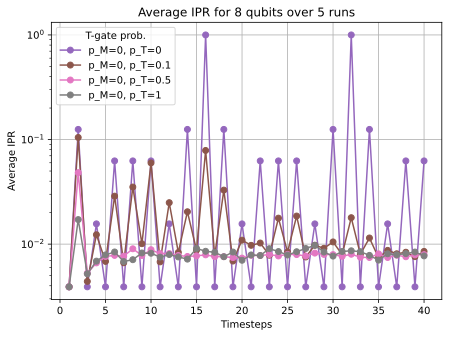

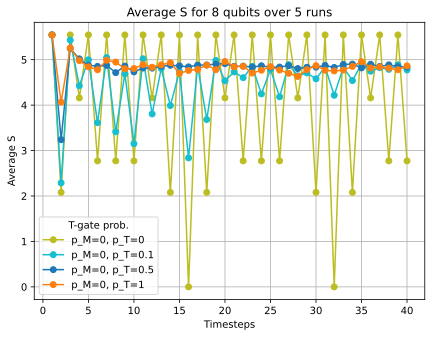

In [5]:
# Plot IPR
plt.figure(figsize=(7, 5))
for (pM, pT), color in zip(combos, colors):
    xi = range(1, D + 1)
    yi = iprs_avg_dict[(pM, pT)][1:]  # skip t=0
    plt.plot(xi, yi, marker='o', color=color, label=f"p_M={pM}, p_T={pT}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average IPR")
plt.yscale('log')
plt.title(f"Average IPR for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="T-gate prob.")
plt.show()

# Plot S
plt.figure(figsize=(7, 5))
for (pM, pT), color in zip(combos, colors):
    xs = range(1, D + 1)
    ys = entropies_avg_dict[(pM, pT)][1:]  # skip t=0
    plt.plot(xs, ys, marker='o', color=color, label=f"p_M={pM}, p_T={pT}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average S")
plt.title(f"Average S for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="T-gate prob.")
plt.show()

In [6]:
p_M = np.linspace(0, 0.5, 21)   # [0.0, 0.05, 0.1, ..., 1.0]
p_T = np.linspace(0, 0.5, 21)
n_runs = 10
L=6
D=25

iprs_final_dict = {}   # to store only final IPR
circuits = {}          # save circuits to draw

combos = [(pM, pT) for pM in p_M for pT in p_T]
for (pM, pT), color in zip(combos, colors):  # loop over combos
    final_iprs = []
    for run in tqdm(range(n_runs), desc=f"Running pM={pM}, pT={pT}", leave=True, ncols=80):
        circ = qtn.CircuitMPS(N=L, max_bond=128, cutoff=1e-9)  # initialize circuit of length L

        # initial IPR should be 1, no need to store

        for r in range(D): # for each layer in depth
            if r % 2 == 0: 
                # at even layers apply random 2-site Clifford
                for i in range(0, L - 1, 2):
                    U = iswap()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (0,1), (2,3), ...
            else:
                for i in range(1, L - 1, 2):
                # at odd layers apply random 2-site Clifford
                    U = iswap()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (1,2), (3,4), ...
            
            for q in range(L): # random single qubit rotation
                circ.apply_gate(qu.rotation(np.pi / 2, xyz='X'), q, gate_round=r, tags=("Rx",))
            for q in range(L): # for each qubit, add T gate with prob pT
                if np.random.rand() < pT:
                    circ.apply_gate(T(), q, gate_round=r, tags=("T",))
            state, outcomes = z_measure(circ, L, pM, rng, round_int=r)
            circ = qtn.Circuit(N=L, psi0=state)

            # attemps at implementing Z-measurements
            #outcomes = z_measure(circ, L, pM, rng, round_int=r) #after each layer, measure with prob p
            #_ = z_measure_subset(circ, qs_all=range(L), pM=pM, round_int=r)
            #outcomes = random_measurement_round(circ, L=L, p=pM, round_int=r)
            #outcomes = z_measure(circ, r, pM)

        # only take final IPR after depth D
        ipr_final = ipr(circ)
        final_iprs.append(ipr_final)

    # average over runs
    iprs_final_dict[(pM, pT)] = np.mean(final_iprs)
    circuits[(pM, pT)] = circ

Running pM=0.07500000000000001, pT=0.05: 100%|██| 10/10 [00:00<00:00, 15.32it/s]
Running pM=0.07500000000000001, pT=0.07500000000000001: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.125: 100%|█| 10/10 [00:00<00:00, 10.03it/s]
Running pM=0.07500000000000001, pT=0.15000000000000002: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.17500000000000002: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.275: 100%|█| 10/10 [00:00<00:00, 12.83it/s]
Running pM=0.07500000000000001, pT=0.30000000000000004: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.325: 100%|█| 10/10 [00:00<00:00, 12.32it/s]
Running pM=0.07500000000000001, pT=0.35000000000000003: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.4: 100%|███| 10/10 [00:00<00:00, 11.95it/s]
Running pM=0.07500000000000001, pT=0.42500000000000004: 100%|█| 10/10 [00:00<00:
Running pM=0.07500000000000001, pT=0.45: 100%|██| 10/10 [00:00<00:00, 10.55it/s]
Running pM=0.075000000000000

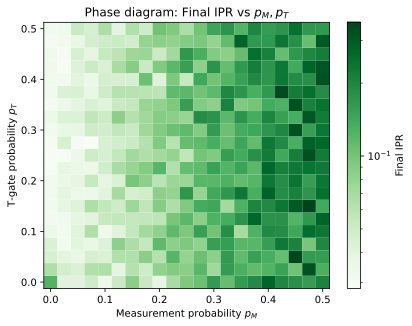

  - Number of qubits (L): 6
  - IPR calculated at circuit depth (D) of: 25 layers
  - Runs averaged over: 10


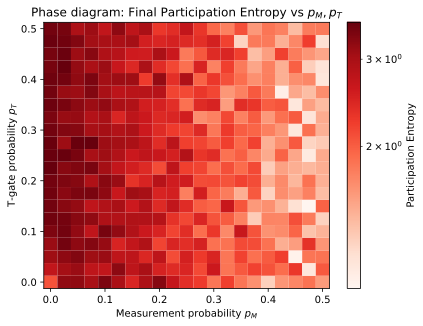

  - Number of qubits (L): 6
  - Participation entropy calculated at circuit depth (D) of: 25 layers
  - Runs averaged over: 10


In [7]:
pM_vals = sorted({k[0] for k in iprs_final_dict})
pT_vals = sorted({k[1] for k in iprs_final_dict})

heatmap = np.full((len(pT_vals), len(pM_vals)), np.nan)

for (pT, pM), ipr_final in iprs_final_dict.items():
    i = pT_vals.index(pM)
    j = pM_vals.index(pT)
    heatmap[i, j] = ipr_final

X, Y = np.meshgrid(pM_vals, pT_vals)
plt.pcolormesh(X, Y, heatmap, shading='auto', cmap='Greens', norm=mcolors.LogNorm())
plt.colorbar(label="Final IPR")
plt.ylabel("T-gate probability $p_T$")
plt.xlabel("Measurement probability $p_M$")
plt.title("Phase diagram: Final IPR vs $p_M, p_T$")
plt.show()

print(f"  - Number of qubits (L): {L}")
print(f"  - IPR calculated at circuit depth (D) of: {D} layers")
print(f"  - Runs averaged over: {n_runs}")

# --- Participation Entropy heatmap (from IPR) ---

pM_vals = sorted({k[0] for k in iprs_final_dict})
pT_vals = sorted({k[1] for k in iprs_final_dict})

heatmap_S = np.full((len(pT_vals), len(pM_vals)), np.nan)

for (pM, pT), ipr_final in iprs_final_dict.items():
    i = pM_vals.index(pM)
    j = pT_vals.index(pT)
    heatmap_S[j, i] = -np.log(ipr_final)  # S = -log(IPR)

X, Y = np.meshgrid(pM_vals, pT_vals)
plt.pcolormesh(X, Y, heatmap_S, shading='auto', cmap='Reds', norm=mcolors.LogNorm())
plt.colorbar(label="Participation Entropy")
plt.ylabel("T-gate probability $p_T$")
plt.xlabel("Measurement probability $p_M$")
plt.title("Phase diagram: Final Participation Entropy vs $p_M, p_T$")
plt.show()

print(f"  - Number of qubits (L): {L}")
print(f"  - Participation entropy calculated at circuit depth (D) of: {D} layers")
print(f"  - Runs averaged over: {n_runs}")